<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align=center><font size="5"> SVM (Machines à vecteurs de support)</font></h1>


Dans ce cahier, vous utiliserez SVM (Machines à vecteurs de support) pour créer et entraîner un modèle à l'aide d'enregistrements de cellules humaines et classer les cellules selon que les échantillons sont bénins ou malins.

SVM fonctionne en mappant les données sur un espace de caractéristiques de grande dimension afin que les points de données puissent être catégorisés, même lorsque les données ne sont pas autrement linéairement séparables. Un séparateur entre les catégories est trouvé, puis les données sont transformées de manière à ce que le séparateur puisse être dessiné comme un hyperplan. Ensuite, les caractéristiques des nouvelles données peuvent être utilisées pour prédire le groupe auquel un nouvel enregistrement devrait appartenir.

<h1>Table des matières</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Charger les données sur le cancer</a></li>
        <li><a href="#modeling">Modélisation</a></li>
        <li><a href="#evaluation">Évaluation</a></li>
        <li><a href="#practice">Pratiquer</a></li>
    </ol>
</div>
<br>
<hr>

In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

<h2 id="load_dataset">Charger les données Cancer</h2>
Téléchargons l'ensemble de données. Nous utiliserons pour les télécharger l'adresse web:  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-Coursera/labs/Data_files/cell_samples.csv. Ensuite nous chargeons le fichier obtenu sur localhost.

### Charger les données à partir du fichier CSV

In [3]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


Le champ ID contient les identifiants du patient. Les caractéristiques des échantillons de cellules de chaque patient sont contenues dans les champs Clump à Mit. Les valeurs sont notées de 1 à 10, 1 étant la plus proche de bénigne.

Le champ Classe contient le diagnostic, tel que confirmé par des procédures médicales distinctes, indiquant si les échantillons sont bénins (valeur = 2) ou malins (valeur = 4).

Regardons la distribution des classes en fonction de l'épaisseur du bouquet et de l'uniformité de la taille des cellules :

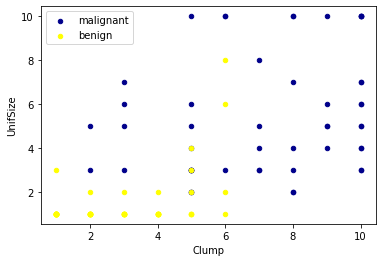

In [4]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Pré-traitement et sélection des données

Examinons d'abord les types de données des colonnes :

In [5]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

Il semble que la colonne **BareNuc** contienne des valeurs qui ne sont pas numériques. Nous pouvons supprimer ces lignes :

In [6]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [7]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

Nous voulons que le modèle prédise la valeur de Class (c'est-à-dire bénigne (=2) ou maligne (=4)). Comme ce champ peut avoir l'une des deux seules valeurs possibles, nous devons modifier son niveau de mesure pour refléter cela.

In [8]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Ensemble de données d'entraînement/test

D'accord, nous divisons notre ensemble de données en train et ensemble de test :

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modélisation (SVM avec Scikit-learn)</h2>

L'algorithme SVM offre un choix de fonctions du noyau pour effectuer son traitement. Fondamentalement, le mappage de données dans un espace de dimension supérieure est appelé noyautage. La fonction mathématique utilisée pour la transformation est connue sous le nom de fonction de noyau et peut être de différents types, tels que :

```
1.Linéaire
2.Polynômiale
3. Fonction de base radiale (RBF)
4.Sigmoïde
```

Chacune de ces fonctions a ses caractéristiques, ses avantages et ses inconvénients, et son équation, mais comme il n'y a pas de moyen simple de savoir quelle fonction fonctionne le mieux avec un ensemble de données donné, nous choisissons généralement différentes fonctions à tour de rôle et comparons les résultats. Utilisons simplement la valeur par défaut, RBF (Radial Basis Function) pour ce laboratoire.

In [10]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

Après avoir été ajusté, le modèle peut ensuite être utilisé pour prédire de nouvelles valeurs :

In [11]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Évaluation</h2>

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


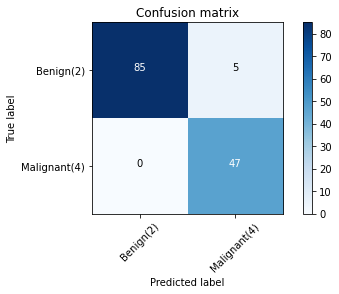

In [14]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Vous pouvez également facilement utiliser le **f1_score** de la bibliothèque sklearn :

In [15]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

<h2 id="practice">Pratique</h2>
Pouvez-vous reconstruire le modèle, mais cette fois avec un noyau __linéaire__ ? Vous pouvez utiliser l'option __kernel='linear'__, lorsque vous définissez le svm. Comment la précision change avec la nouvelle fonction du noyau ?

In [20]:
# write your code here

Double-click **Ici** for the solution.

<!-- Your answer is below:
    
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, yhat2))

-->

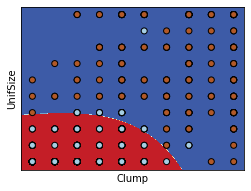

In [17]:
X = X[:, [0, 1]]  # we only take the first two features.
Y = y

# Create an instance of Logistic Regression Classifier and fit the data.
clf = svm.SVC(kernel='rbf')
clf.fit(X, Y)
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
#plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired,shading='auto')
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Clump')
plt.ylabel('UnifSize')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD est un Data Scientist chez IBM avec une expérience dans le développement d'applications au niveau de l'entreprise qui augmente considérablement la capacité des clients à transformer les données en connaissances exploitables. Il est chercheur dans le domaine de l'exploration de données et expert dans le développement de méthodes analytiques avancées telles que l'apprentissage automatique et la modélisation statistique sur de grands ensembles de données.</p>


<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>
